# Garmin Health Data Analysis
<p>I decided to obtain all of my health data after wearing my Garmin smart watch for the past year to see if I could find any interesting correlations between my sleep, health and activity statistics.</p>

<p><img style="float: right;margin:5px 20px 5px 1px; max-width:350px" src="https://logos-world.net/wp-content/uploads/2020/12/Garmin-Emblem.png"></p>
<p>Whilst the data for the previous 7 days is readily available and well displayed in the Garmin app, I wanted to go deeper to see if i could come to any conclusions about my sleep patterns from various factors to help me sleep better in the future.</p>
<p>Firstly, I requested the data from Garmin. It came in a messy and separate fashion which I combed through and decided to use the following for the analysis:</p>
<p>- Exercise data in one csv file</p>
<p>- Metrics data (including heartrate and steps taken per day) in four JSON files</p>
<p>- Sleep data in four JSON files</p>

In [21]:
# import libraries required for the analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime

# 1. Importing the Data

### 1.1 Activity Data

In [22]:
#Import Activities data which comes in one csv
activities = pd.read_csv('activities.csv')

### 1.2 Metrics Data

In [23]:
#Write a function to allow for quicker concatenation of 4 JSON files
def jsonread_concat(jsonA, jsonB, jsonC, jsonD):
    A = pd.read_json(jsonA)
    B = pd.read_json(jsonB)
    C = pd.read_json(jsonC)
    D = pd.read_json(jsonD)
    return pd.concat([A, B, C, D], ignore_index=True)

In [24]:
#Import the metrics data using the jsonread_concat function
metrics = jsonread_concat('metrics.json', 'metrics_b.json', 'metrics_c.json', 'metrics_d.json')

### 1.3 Sleep Data

In [25]:
#Import the sleepdata data using the jsonread_concat function
sleepdata = jsonread_concat('sleepdata_A.json', 'sleepdata_B.json', 'sleepdata_C.json', 'sleepdata_D.json')

#Add additional columns to get total sleep time in hours
sleepdata['total_sleep_hourdec'] = ((sleepdata['deepSleepSeconds']+sleepdata['lightSleepSeconds']+sleepdata['remSleepSeconds'])/(60*60)).astype('float')
sleepdata['rem_sleep_hourdec'] = (sleepdata['remSleepSeconds']/(60*60)).astype('float')


# 2. Merge the Three Dataframes into One

In [26]:
#Date is the best column to merge on, create functions to convert date in each dataframe into the same format

#Function 1 for the dates in Metrics Data
def dfs(dts):
    dt = datetime.datetime.strptime(dts, '%b %d, %Y %I:%M:%S %p').date()
    return dt
#Test dfs
date_time_str = 'Jul 2, 2020 2:00:00 PM'
print('Date:', dfs(date_time_str))


#Function 2 for the dates in Metrics Data
def dfs2(dts):
    dt = datetime.datetime.strptime(dts, '%Y-%m-%d').date()
    return dt
#Test dfs2
date_time_str_2 = '2020-07-02'
print('Date2:', dfs2(date_time_str_2))

Date: 2020-07-02
Date2: 2020-07-02


In [27]:
#Convert 'date' of activity to the same format as the other data frames which this is to be merged with
activities['Date'] = activities['Date'].astype('str')
activities[['date','time']] = activities.Date.str.split(" ", expand=True,)
activities['date'] = activities['date'].apply(dfs2)
activities.head()

#Convert 'date' columns in metrics
metrics = metrics.drop(218, axis=0)
metrics = metrics.rename(columns={'restingHeartRateTimestamp': 'date'})
metrics['date'] = metrics['date'].astype('str')
metrics['date'] = metrics['date'].apply(dfs)
metrics.head()

#convert 'date' columns in sleepdata
sleepdata = sleepdata.rename(columns={'calendarDate': 'date'})
sleepdata['date'] = sleepdata['date'].apply(dfs2)


In [28]:
#Merge each of the dataframes on the 'date' column and call it slp_met_act
slp_met = pd.merge(sleepdata, metrics, how= 'left', on= 'date')
slp_met_act = pd.merge(slp_met, activities, how= 'left', on= 'date')

#Do any additional cleanup of data (drop na rows and remove rows with sleep outliers [Sleep > 4 hours or < 10 hours] to allow calculations and trends to be determined)
slp_met_act = slp_met_act[slp_met_act['total_sleep_hourdec'].notna() & slp_met_act['maxAvgHeartRate'].notna()& slp_met_act['rem_sleep_hourdec'].notna()]
slp_met_act = slp_met_act.drop(slp_met_act[slp_met_act['total_sleep_hourdec'] > 10].index)
slp_met_act = slp_met_act.drop(slp_met_act[slp_met_act['total_sleep_hourdec'] < 4].index)

# 3. Initial Data Visualisation
<p>Compare the sleep data against a number of health statistics to see if there is any correlation between a good sleep and a specific metric each day.</p>

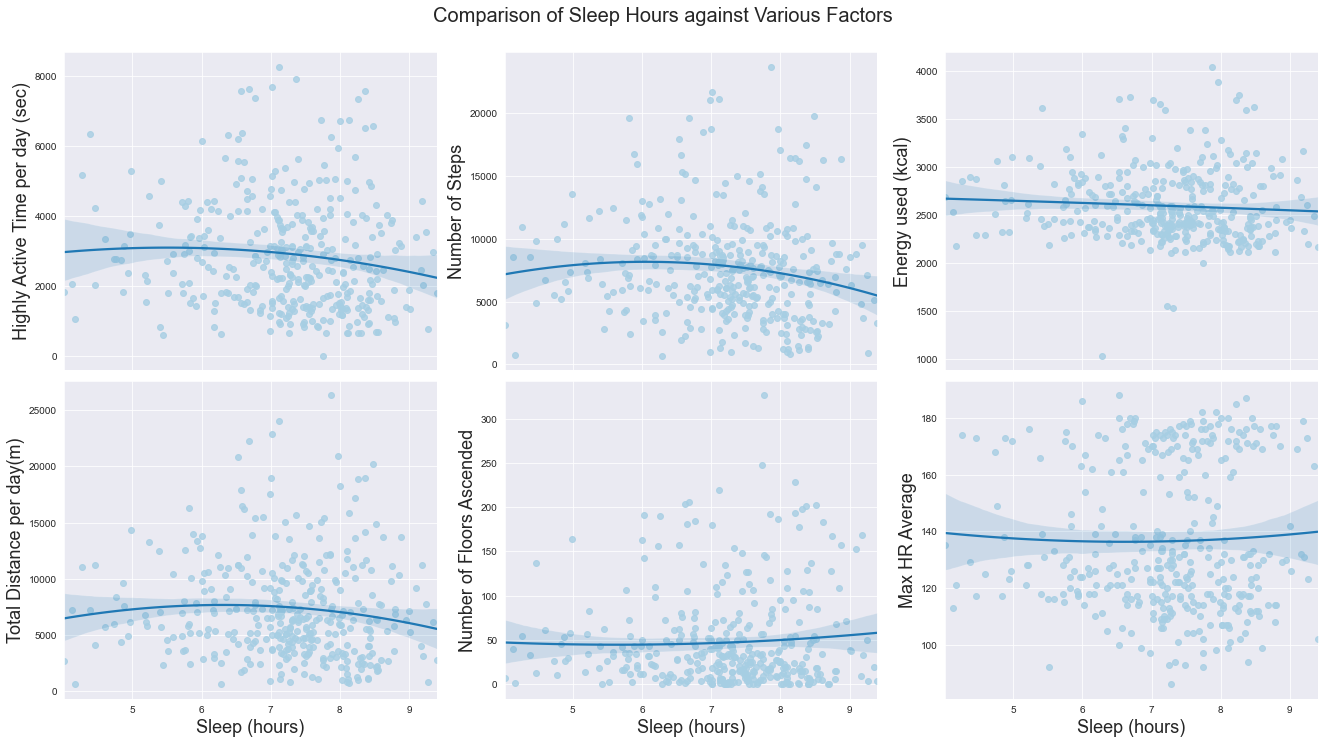

In [29]:
#set figure and axes
fig, axs = plt.subplots(2, 3, sharex='col')
fig.set_size_inches(18.5, 10.5)

#Make a graph for each one of the grids
sns.regplot(ax=axs[0, 0], x='total_sleep_hourdec', y='highlyActiveSeconds', data=slp_met_act, line_kws={'color' : 'C1'}, order=2)
sns.regplot(ax=axs[0, 1], x='total_sleep_hourdec', y='totalSteps', data=slp_met_act, line_kws={'color' : 'C1'}, order=2)
sns.regplot(ax=axs[0, 2], x='total_sleep_hourdec', y='totalKilocalories', data=slp_met_act, line_kws={'color' : 'C1'}, order=2)
sns.regplot(ax=axs[1, 0], x='total_sleep_hourdec', y='totalDistanceMeters', data=slp_met_act, line_kws={'color' : 'C1'}, order=2)
sns.regplot(ax=axs[1, 1], x='total_sleep_hourdec', y='floorsAscendedInMeters', data=slp_met_act, line_kws={'color' : 'C1'}, order=2)
sns.regplot(ax=axs[1, 2], x='total_sleep_hourdec', y='maxAvgHeartRate', data=slp_met_act, line_kws={'color' : 'C1'}, order=2)

#Set respective x and x axis titles
axs[0, 0].set_xlabel("")
axs[0, 0].set_ylabel("Highly Active Time per day (sec)", fontsize=18)
axs[0, 1].set_xlabel("")
axs[0, 1].set_ylabel("Number of Steps", fontsize=18)
axs[0, 2].set_xlabel("")
axs[0, 2].set_ylabel("Energy used (kcal)", fontsize=18)
axs[1, 0].set_xlabel("Sleep (hours)", fontsize=18)
axs[1, 0].set_ylabel("Total Distance per day(m)", fontsize=18)
axs[1, 1].set_xlabel("Sleep (hours)", fontsize=18)
axs[1, 1].set_ylabel("Number of Floors Ascended", fontsize=18)
axs[1, 2].set_xlabel("Sleep (hours)", fontsize=18)
axs[1, 2].set_ylabel("Max HR Average", fontsize=18)

#Finalise and show
fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle('Comparison of Sleep Hours against Various Factors', fontsize=20)
plt.show()

# 4. Targeted Sleep Analysis Overtime
<p>Based on the data, it appears that generally on days with a higher maximum heart rate (max HR average), the sleep also increases. Lets take a closer look at this by placing the data from the year on a plot to see whether there is a correlation between periods of good sleep and periods of higher max HR average. We'll obtain a rolling average for sleep length and max HR for a 28 day period to see if a correlation exists.</p>

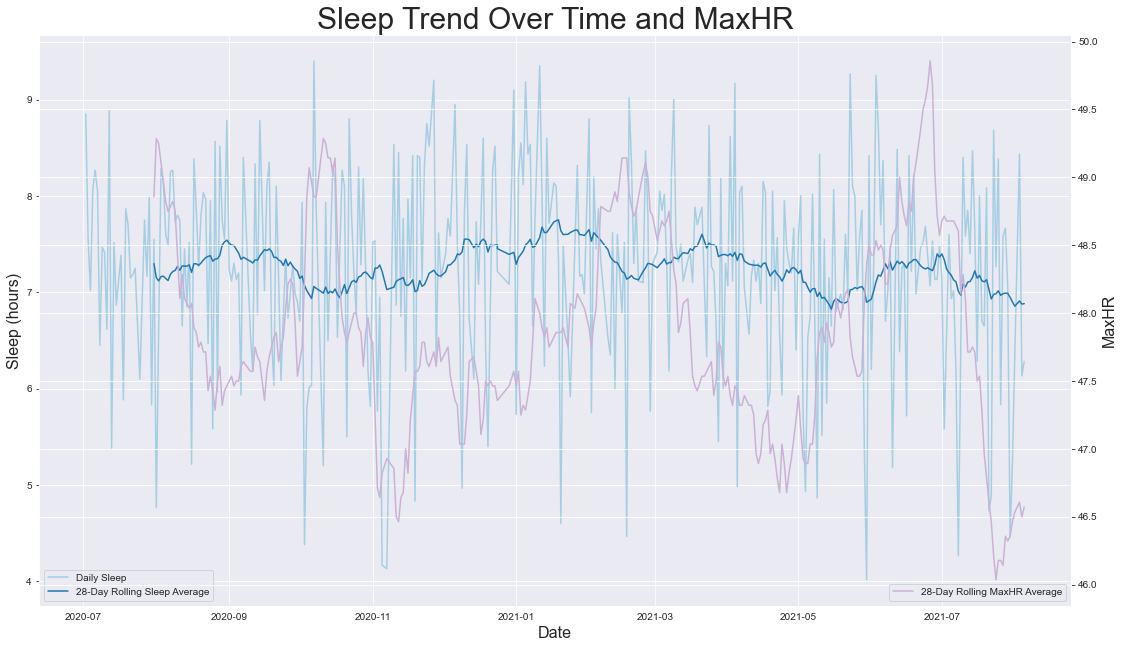

In [30]:
sns.set_palette("Paired")
sns.set_style("darkgrid")

#Find Rolling Averages and add to the data frame
slp_met_act['rolling_sleep_average_28day'] = slp_met_act.iloc[:,10].rolling(window=28).mean()
slp_met_act['rolling_maxHR_average_28day'] = slp_met_act.iloc[:,54].rolling(window=28).mean()

#Rolling Sleep Plot - set figure and axes
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

#ax1 - Sleep and Rolling sleep average
ax.plot(slp_met_act['date'], slp_met_act['total_sleep_hourdec'], label='Daily Sleep')
ax.plot(slp_met_act['date'], slp_met_act['rolling_sleep_average_28day'], label='28-Day Rolling Sleep Average')
ax.legend(loc=3)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Sleep (hours)', fontsize=16)

#ax2
ax2 = ax.twinx()
ax2.plot(slp_met_act['date'], slp_met_act['rolling_maxHR_average_28day'], label='28-Day Rolling MaxHR Average', color="C8")
ax2.set_ylabel('MaxHR', fontsize=16)
ax2.legend(loc=4)

#Finalise and show plot
plt.title('Sleep Trend Over Time and MaxHR', fontsize=30)
plt.show()

# 5. Comparing Sleep on Days of Exercise and Days of No Exercise
<p>It does appear that there may be a correlation however we'll need to look a closer to be sure. Let's now look at days where exercise was completed and then, specifically, at days of more intense exercise (i.e. days that the max HR was above 170 bpm).</p>

In [31]:
#Find average sleep for days of activities
slp_met_act['if_active'] = slp_met_act['Distance'].isnull().astype(int) 
avslp_active = slp_met_act.groupby('if_active')['total_sleep_hourdec'].mean().reset_index(name='av_sleep')
remslp_active = slp_met_act.groupby('if_active')['rem_sleep_hourdec'].mean().reset_index(name='av_rem')
av_rem_slp = pd.merge(avslp_active, remslp_active, how= 'left', on= 'if_active')
avslp_active.head()
av_rem_slp.head()

,if_active,av_sleep,av_rem
0,0,7.334626,2.153736
1,1,7.201071,2.052878


In [32]:
#Find average sleep for days of high average HR
slp_met_act["hr>170"] = np.where(slp_met_act["maxAvgHeartRate"]>=170, "Yes", "No")
avslp_HR = slp_met_act.groupby('hr>170')['total_sleep_hourdec'].mean().reset_index(name='av_sleep')
avslp_HR.head()

,hr>170,av_sleep
0,No,7.206330
1,Yes,7.380342


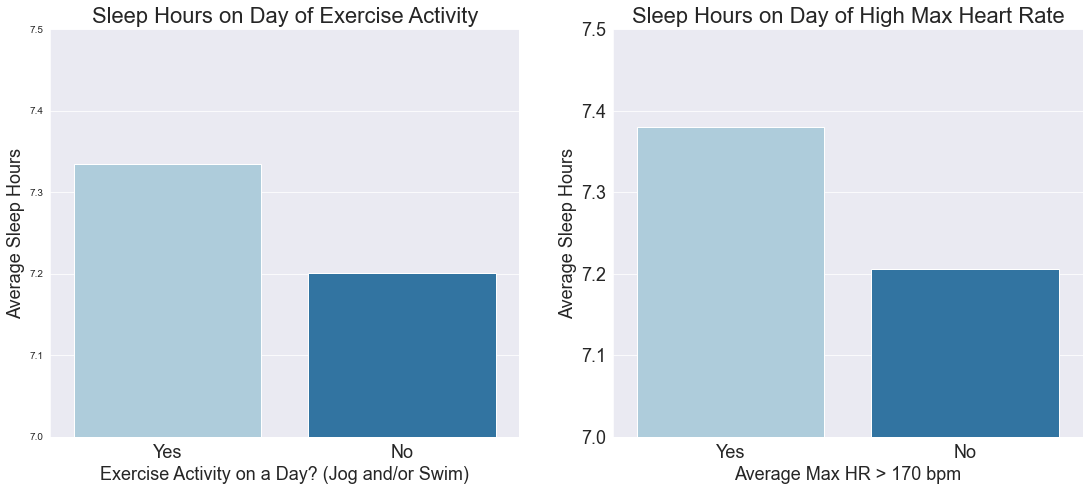

In [33]:
#Set Figure and Axes
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18.5, 7.5)
sns.set_palette("Paired")

#Plot A
sp1 = sns.barplot(ax=axs[0], x='if_active', y='av_sleep', data = avslp_active)
sp1 = sp1.set(ylim=(7,7.5))
axs[0].set_title("Sleep Hours on Day of Exercise Activity", fontsize=22)
axs[0].set_xlabel("Exercise Activity on a Day? (Jog and/or Swim)", fontsize=18)
axs[0].set_ylabel("Average Sleep Hours", fontsize=18)
plt.sca(axs[0])
plt.xticks([0, 1], ['Yes','No'], fontsize=18)

#Plot B
sp2 = sns.barplot(ax=axs[1], x='hr>170', y='av_sleep', data = avslp_HR, order=["Yes", "No"])
sp2 = sp2.set(ylim=(7,7.5))
axs[1].set_title("Sleep Hours on Day of High Max Heart Rate", fontsize=22)
axs[1].set_xlabel("Average Max HR > 170 bpm", fontsize=18)
axs[1].set_ylabel("Average Sleep Hours", fontsize=18)
plt.sca(axs[1])

#Finalise Plot and Show
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# 6. Days of Exercise
<p>We can now definitely see that on average over a full year, days where exercise is completed results in better sleep than days where no exercise is completed. Additionally, we see that days where more intense exercise is completed (max HR was greater than 170 bpm) has resulted in better sleep again. Now lets compare the types of exercise to see if there's any correlation there. Is there a correlation between the type and length of the exercise and how good the sleep is?</p>

In [34]:
#Filter so only rows with days of exercise are showing
activity_days = slp_met_act[slp_met_act['Activity Type'].notna()].reset_index()

#See how many activities were completed for each activity category
activity_days['Activity Type'].value_counts().head()

Running          113
Pool Swimming      3
Name: Activity Type, dtype: int64

In [35]:
#Create a function to convert time string to minutes

def minutes(time_l):
    tm_a = time.strptime(time_l,'%H:%M:%S')
    tm = datetime.timedelta(hours=tm_a.tm_hour,minutes=tm_a.tm_min,seconds=tm_a.tm_sec).total_seconds()
    the_time = tm/60
    return the_time

#Test minutes function
time_str = '00:30:00'
print(minutes(time_str))

30.0


In [36]:
#Apply minutes function to 'Time' column to obtain minutes of activities each day
activity_days['activity_mins'] = activity_days['Time'].apply(minutes)

In [37]:
#Summary of activity times
activity_days['activity_mins'].describe()

count    116.000000
mean      35.102730
std       13.531352
min       14.400000
25%       24.504167
50%       34.341667
75%       38.791667
max       90.666667
Name: activity_mins, dtype: float64

In [38]:
#Summary of Runs distances
activity_days_runs = activity_days.drop(activity_days[activity_days['Activity Type'] == 'Pool Swimming'].index)
activity_days_runs['Distance'] = activity_days_runs['Distance'].astype('float')
activity_days_runs['Distance'].describe()

count    113.000000
mean       7.441062
std        2.832999
min        2.970000
25%        5.210000
50%        7.020000
75%        8.120000
max       18.510000
Name: Distance, dtype: float64

In [39]:
#Average sleep for long runs (>40 mins) vs short runs (<40 mins)
activity_days_runs["run>40"] = np.where(activity_days_runs["activity_mins"]>=40, "Running>40mins", "Running<40mins")
avslp_runs = activity_days_runs.groupby('run>40')['total_sleep_hourdec'].mean().reset_index(name='av_sleep')
avslp_runs.columns = ['Activity Type', 'av_sleep']

#Average sleep on nights of swimming amd running activity then concatenate with each other and add No Exercise sleep average for comparison
activity_days_swims = activity_days.drop(activity_days[activity_days['Activity Type'] == 'Running'].index)
avslp_swims = activity_days.groupby('Activity Type')['total_sleep_hourdec'].mean().reset_index(name='av_sleep')
avslp_noexercise = pd.DataFrame({'Activity Type':['No Exercise'], 'av_sleep': [7.201071]})
avslp_acts = pd.concat([avslp_swims, avslp_runs, avslp_noexercise])
avslp_acts.head()

,Activity Type,av_sleep
0,Pool Swimming,7.411111
1,Running,7.332596
0,Running<40mins,7.300370
1,Running>40mins,7.458696
0,No Exercise,7.201071


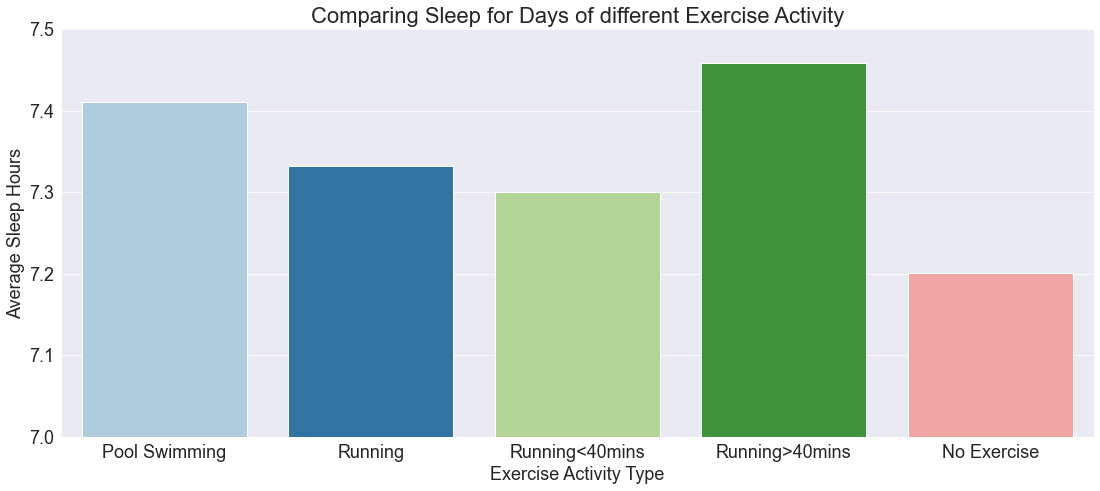

In [40]:
#Creata figure and axes
fig, axs = plt.subplots()
fig.set_size_inches(18.5, 7.5)
sns.set_palette("Paired")

#Make Plot
sp1 = sns.barplot(x='Activity Type', y='av_sleep', data = avslp_acts)
sp1 = sp1.set(ylim=(7,7.5))

#Customise and show
plt.title("Comparing Sleep for Days of different Exercise Activity", fontsize=22)
plt.xlabel("Exercise Activity Type", fontsize=18)
plt.ylabel("Average Sleep Hours", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Conclusion
<p>Based on the data from the past year, it is fair to say that on average there is an improvement in sleep on a day that I undertook high intensity exercise where my heart rate rose above 170 and that the best sleep was on days where I completed a long run (a run greater than 40 minutes).</p> 
<p>Therefore, based on this analysis, one can conclude that undertaking high intensity exercise during that day, preferably for greater than 40 minutes, will increase my sleep quality.</p>